About: Loan Defaulters Classifications
Dataset1: Dataset link - https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

Experimental Aim: To compare the performance of loan defaulters classifications using ML classifiers and neural  network

Results: Performance accuracy

Processses:
- exploratory data analysis
- multi-model learning and performance comparison


In [81]:
# set up

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from IPython.display import clear_output
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, precision_recall_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn import tree

from sklearn import datasets, linear_model
#import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from scipy import stats
from sklearn.ensemble import ExtraTreesClassifier

#set fiqure size to control all plt plottings
plt.rcParams['figure.figsize']=(10,5)

In [4]:
from time import sleep
from joblib import Parallel, delayed

## data upload and pre-processing
- upload using pandas
- preprocessing and engineering using one-hot encoding

In [58]:
# upload data dataframe 
df = pd.read_csv('default_of_credit_card_clients.csv', skiprows=1)
     # removing rows with null values if any 
df.head(2)    # print sample frame by rows
#df.columns

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1


In [61]:
# perform one-hot encoding for category variables

# generate numeric variables from category variables
df1 = pd.concat([df.drop('SEX', axis=1), pd.get_dummies(df['SEX'],prefix='sex')], axis=1)
df2 = pd.concat([df1.drop('EDUCATION', axis=1), pd.get_dummies(df1['EDUCATION'],prefix='edu')], axis=1)
df3 = pd.concat([df2.drop('MARRIAGE', axis=1), pd.get_dummies(df2['MARRIAGE'],prefix='married')], axis=1)
data1 = df3.rename(columns= {'default payment next month': 'default_payment'})
data1.columns

Index(['ID', 'LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5',
       'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
       'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
       'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default_payment', 'sex_1', 'sex_2',
       'edu_0', 'edu_1', 'edu_2', 'edu_3', 'edu_4', 'edu_5', 'edu_6',
       'married_0', 'married_1', 'married_2', 'married_3'],
      dtype='object')

In [67]:
# data cleaning based on the key requirements

remov= ['ID', 'edu_0', 'edu_5','edu_6', 'married_0']
credit_data = data1.drop(remov, axis = 1)
credit_data.head(2)

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,default_payment,sex_1,sex_2,edu_1,edu_2,edu_3,edu_4,married_1,married_2,married_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,1,0,1,0,1,0,0,1,0,0
1,120000,26,-1,2,0,0,0,2,2682,1725,...,1,0,1,0,1,0,0,0,1,0


## exploratory data analysis
1. outlier removal
- univariate approach
- multivariate approach 

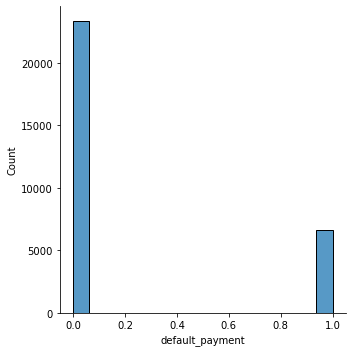

In [86]:
# percentage class distribution among variables

import seaborn as sns
dataplt =sns.displot(credit_data['default_payment'])
print(dataplt)

<AxesSubplot:>

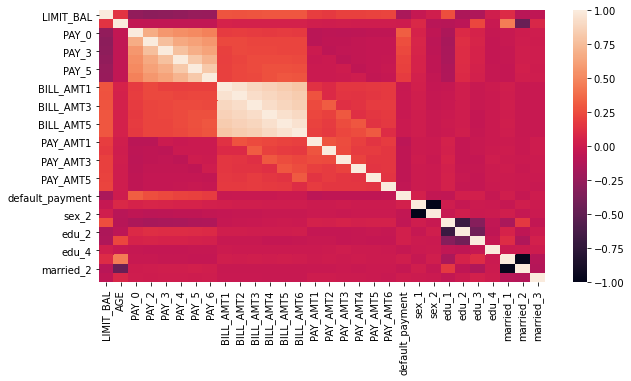

In [100]:
# heatmap showing correlations between variables
sns.heatmap(credit_data.corr())

# there is positive and negative correlations between variables
# this will require features correction selection


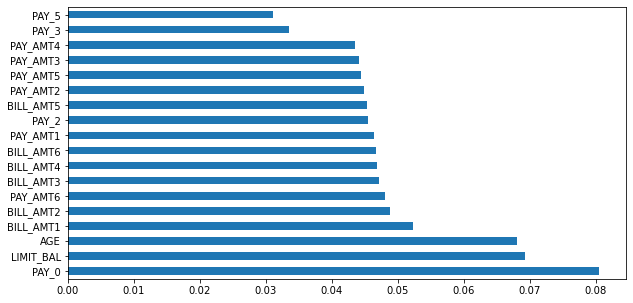

In [75]:
# input and target data separation
targetname = 'default_payment'
X = credit_data.drop(targetname, axis =1)
y = credit_data[targetname]

# variables fitting with random state declared to ensure reproducibility of result
feat_model = ExtraTreesClassifier(n_estimators=100, random_state=0, criterion = 'entropy')
feat_model1 = feat_model.fit(X,y)

# performance score evaluation
#print('Feature Selection Score is: {0:0.2f}'.format(perf_selection))

#visualisation of features importance, nlargest number can be changed to the desire number of features needed
feat_importances = pd.Series(feat_model.feature_importances_,index=X.columns)    # track all columns by score ranks
feat_importances.nlargest(18).plot(kind='barh')         # filtered only best selected columns by score values
plt.show()

In [82]:
# select the best features with largest possible score pairwise correlection metrics

n = 14        # number of best features of interest
            # this can be used as a parameter to monitor classification performance
   
X_dt =credit_data[feat_importances.nlargest(n).index] # derived features from decision tree (X_dt)
print(X_dt.columns)     # to see the best selected features

# scaling and tranformation of input features(X)

#StandardScaler = StandardScaler()
MinMax_Scaler = MinMaxScaler()
X11 = MinMax_Scaler.fit_transform(X_dt)
X1 = stats.zscore(X11)    # normalises input data using mean and std derived from the data 
y1 = y     # target variable (Sale)

Index(['PAY_0', 'LIMIT_BAL', 'AGE', 'BILL_AMT1', 'BILL_AMT2', 'PAY_AMT6',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT6', 'PAY_AMT1', 'PAY_2', 'BILL_AMT5',
       'PAY_AMT2', 'PAY_AMT5'],
      dtype='object')


In [97]:
# Data splits

# perform train (70%) and validation test(30%) data split
X_train, X_testn, y_train, y_testn = train_test_split(X1, y1, test_size=0.3, random_state=42)
print(len(X_train))    # output from row 2 train dataset

# additional test dataset for statistical check
X_test1, X_test2n, y_test1, y_test2n = train_test_split(X_testn, y_testn, test_size=0.3, random_state=42)
print(len(X_test1))

X_test2, X_test3, y_test2, y_test3 = train_test_split(X_test2n, y_test2n, test_size=0.3, random_state=42)
print(len(X_test2))
print(len(X_test3))
y_test3.index[26]

21000
6300
1890
810


12573

In [93]:
# Construct learning pipelines for classification model

#support vector machine
pipe_svm = Pipeline([('p1', MinMaxScaler()),
                      ('svm', svm.SVC(random_state = 5))])

# logistic regression
pipe_lr = Pipeline([('p2', MinMaxScaler()),
                     ('lr', LogisticRegression(random_state=20))])

# adaboost
pipe_ada = Pipeline([('p3', MinMaxScaler()),
                      ('ada', AdaBoostClassifier(n_estimators = 100, random_state = 20))])

# KNN
pipe_knn = Pipeline([('p4', MinMaxScaler()),
                      ('knn', KNeighborsClassifier(n_neighbors=6, metric='euclidean'))])

# Random Forest (rf) network
num_trees =100
max_features = 14
pipe_rf = Pipeline([('p5', MinMaxScaler()),
                      ('rf', RandomForestClassifier(n_estimators=num_trees,
                                                    max_features=max_features))])

# create a list of pipeline and fit training data on it

classifier_pipe = [pipe_svm, pipe_lr, pipe_ada, pipe_knn, pipe_rf]

# fit the training data on the classifier pipe

for pipe in classifier_pipe:
    pipe.fit(X_train, y_train)
    

In [94]:
# Performance on train and test data sets

#create dictionary of pipeline classifiers
pipe_dic = {0: 'svm', 1: 'lr',
2:'adaboost', 3: 'knn', 4: 'rf'}

# test the performance on train data samples

perf_train = []

for indx, val in enumerate(classifier_pipe):
    perf_trg = pipe_dic[indx], val.score(X_train,y_train)
    perf_train.append(perf_trg)
    
# performance on test1 data samples
perf_test1 = []

for indx, val in enumerate(classifier_pipe):
    perf_tst1 = pipe_dic[indx], val.score(X_test1,y_test1)
    perf_test1.append(perf_tst1)

# performance on test2 data samples   
perf_test2 = []
    
for indx, val in enumerate(classifier_pipe):
    perf_tst2 = pipe_dic[indx], val.score(X_test2,y_test2)
    perf_test2.append(perf_tst2)    
    
    
# tabulated performance between train data samples and test data samples
pd_ptrain = pd.DataFrame(perf_train)
pd_ptest1 = pd.DataFrame(perf_test1)
pd_ptest2 = pd.DataFrame(perf_test2)

# concate dataframes
perf_log = pd.concat([pd_ptrain.rename(columns={ 0: 'Classifiers', 1: 'train_performance'}),
                      pd_ptest1.rename(columns={ 0: 'Classifiers1', 1: 'val1_performance'}),
                      pd_ptest2.rename(columns={ 0: 'Classifiers2', 1: 'val2_performance'})], axis = 1)

perf_log = perf_log.drop(['Classifiers1','Classifiers2'], axis =1)
perf_log

# plot
#ax = sns.barplot(x="Classifiers", y="train_performance", data=perf_log)


,Classifiers,train_performance,val1_performance,val2_performance
0,svm,0.820857,0.822381,0.812698
1,lr,0.809762,0.808254,0.801587
2,adaboost,0.819571,0.817778,0.809524
3,knn,0.833095,0.807937,0.796825
4,rf,0.998381,0.814921,0.806349


In [95]:
# model prediction accuarcy measurement
# accuracy_score is used because of multilabel classification based on jaccard similarity coefficient score

y_predicted = pipe_rf.predict(X_test3)
y_score =accuracy_score(y_test3,y_predicted)

print('Multi Classification score: {0:0.2f}'.format(
      y_score))


Multi Classification score: 0.82


In [96]:
# classification output for test
# using tn, fp, fn, tp, classfication precision can be computed

tn, fp, fn, tp = confusion_matrix(y_test3, y_predicted).ravel()


print(tn, fp, fn, tp)   # output

# output explanation for 27 sales samples classification (default payment = 1, non_default payment = 0)
# tp: 596 are truely classified as sold items
# tn: 30 are wrongly classified as sold items, which should be unsold items
# fp: 117 are classified as unsold items but are actually sold items
# fn: 67 items should belong to sold items but classified as not sold

596 30 117 67


In [101]:
# crosstab visualisations
# comparing ground truth values with the y_predicted labels
pd.crosstab(y_test3 ,y_predicted)


col_0,0,1
default_payment,,
0,596,30
1,117,67


## Neural Network method


In [139]:
# model a dense neural network classifier

from tensorflow import keras

model = keras.Sequential(
    [
        keras.layers.Dense(
            1024, activation="relu", input_shape=(X_train.shape[-1],)
        ),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1024)              15360     
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 1025      
Total params: 2,115,585
Trainable params: 2,115,585
Non-trainable params: 0
____________________________________________

In [140]:
# compile

model.compile(
    optimizer=keras.optimizers.Adam(1e-2), loss="binary_crossentropy", metrics= ['accuracy']
)


In [142]:
# training with class weight

model.fit(
    X_train,
    y_train,
    batch_size=1024,
    epochs=10,
    verbose=2,
    #callbacks=callbacks,
    validation_data=(X_test3, y_test3),
    
)

Train on 21000 samples, validate on 810 samples
Epoch 1/10
21000/21000 - 2s - loss: 0.4328 - accuracy: 0.8203 - val_loss: 0.4415 - val_accuracy: 0.8160
Epoch 2/10
21000/21000 - 2s - loss: 0.4330 - accuracy: 0.8216 - val_loss: 0.4408 - val_accuracy: 0.8160
Epoch 3/10
21000/21000 - 2s - loss: 0.4302 - accuracy: 0.8203 - val_loss: 0.4440 - val_accuracy: 0.8111
Epoch 4/10
21000/21000 - 2s - loss: 0.4350 - accuracy: 0.8214 - val_loss: 0.4415 - val_accuracy: 0.8222
Epoch 5/10
21000/21000 - 2s - loss: 0.4301 - accuracy: 0.8221 - val_loss: 0.4409 - val_accuracy: 0.8160
Epoch 6/10
21000/21000 - 2s - loss: 0.4316 - accuracy: 0.8199 - val_loss: 0.4324 - val_accuracy: 0.8247
Epoch 7/10
21000/21000 - 2s - loss: 0.4340 - accuracy: 0.8190 - val_loss: 0.4433 - val_accuracy: 0.8148
Epoch 8/10
21000/21000 - 2s - loss: 0.4334 - accuracy: 0.8203 - val_loss: 0.4429 - val_accuracy: 0.8123
Epoch 9/10
21000/21000 - 2s - loss: 0.4368 - accuracy: 0.8199 - val_loss: 0.4433 - val_accuracy: 0.8160
Epoch 10/10
2100

## Optimizations 


In [110]:
# finding the best model parameters

model_params = {
    'pipe_svm': {
        'model': svm.SVC(gamma ='auto'),
        'params': {
            'C': [5, 8],
            'kernel': ['rbf','linear']
        }
    }}

In [143]:
# optimization method 1 - GridsearchCV parameters selection technique, -1 using all processors, any int for parrallel 
scores = []

for model_name,xp in model_params.items():
    clf = GridSearchCV(xp['model'], xp['params'], cv=None, n_jobs=-1, return_train_score=False)
    clf.fit(X_test3, y_test3)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
scores

[{'model': 'pipe_svm',
  'best_score': 0.8123456790123458,
  'best_params': {'C': 8, 'kernel': 'rbf'}}]